In [1]:
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append("..")
import pickle
from peft import get_peft_model
import json
from tqdm import tqdm
import openai
import pandas as pd
from data.dataloader import get_dataloader
from helper.dataloader import load_pickle, map_title_to_id, map_id_to_title
import re
from torch.utils.data import DataLoader, Subset
import torch
import os
from dotenv import load_dotenv
from model.MF import MatrixFactorizationLLM,sentenceT5Classification
from model.decoderMLP import decoderMLP, decoderAttention
from model.transformerModel import movieTransformer
import argparse
from torch.optim.lr_scheduler import LambdaLR
from helper.eval_metrics import precision_at_k, recall_at_k, mapk, ndcg_k
from helper.dataloader import *
from trainer.training_utils import *
import wandb
from tqdm import tqdm
import math
from trainer.transformer_utilts import *
from torch.nn.parallel import DataParallel
from peft import LoraConfig, TaskType
from transformers import T5ForSequenceClassification
#import mp 
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from model.MF import MatrixFactorizationLLM,T5MappingVAE,sentenceT5Classification,sentenceT5ClassificationFrozen
import hashlib
from model.MF import T5MappingVAE
os.chdir('../')

#set export MASTER_ADDR="127.0.0.1" as in os 
os.environ['MASTER_ADDR'] = '127.0.0.1'

#same with master port  export MASTER_PORT=$(expr 10000)

os.environ['MASTER_PORT'] = '10000'

    


args = parse_args(notebook=True)

debug_string  = "debug" if args.debug else ""
args.debug_prompts = True  
args.loss = 'bce_softmax'

if args.debugger:
    import debugpy
    debugpy.listen(5678)
    print('attach please')
    debugpy.wait_for_client()
    
def cleanup():
    dist.destroy_process_group()
    
def setup(rank,world_size):
    assert torch.distributed.is_available()
    print("PyTorch Distributed available.")
    print("  Backends:")
    print(f"    Gloo: {torch.distributed.is_gloo_available()}")
    print(f"    NCCL: {torch.distributed.is_nccl_available()}")
    print(f"    MPI:  {torch.distributed.is_mpi_available()}")
 
    # NOTE: the env:// init method uses FileLocks, which sometimes causes deadlocks due to the
    # distributed filesystem configuration on the Mila cluster.
    # For multi-node jobs, use the TCP init method instead.
   

     # DDP Job is being run via `srun` on a slurm cluster.
    # rank = int(os.environ["SLURM_PROCID"])
    # local_rank = int(os.environ["SLURM_LOCALID"])
    # world_size = int(os.environ["SLURM_NTASKS"])
 
     # SLURM var -> torch.distributed vars in case needed
     # NOTE: Setting these values isn't exactly necessary, but some code might assume it's
     # being run via torchrun or torch.distributed.launch, so setting these can be a good idea.
    os.environ["RANK"] = str(rank)
    # os.environ["LOCAL_RANK"] = str(local_rank)
    os.environ["WORLD_SIZE"] = str(world_size)
 
    torch.distributed.init_process_group(
         backend="nccl",
        init_method="env://",
         world_size=world_size,
         rank=rank,
     )
rank = 0
world_size = 1


# setup(rank, world_size)



/home/mila/e/emiliano.penaloza/llm4rec/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MODEL NAME = /home/mila/e/emiliano.penaloza/scratch/saved_model/ml-100k/Transformer/best_model_lr_0.0001_embedding_module_t5_epochs_3_l2_lambda_0.0001_lora_alpha_16_lora_r_16_bce_softmax__bias_False.pth


In [2]:
train_data = pd.read_csv(f'./data_preprocessed/{args.data_name}/train_leave_one_out_timestamped.csv')
train_data = train_data[train_data.rating >= 4]
valid_data = pd.read_csv(f'./data_preprocessed/{args.data_name}/validation_leave_one_out_timestamped.csv')
valid_data = valid_data[valid_data.userId.isin(train_data.userId.unique())]
test_data = pd.read_csv(f'./data_preprocessed/{args.data_name}/test_leave_one_out_timestamped.csv')
test_data = test_data[test_data.userId.isin(train_data.userId.unique())]
strong_generalization_set = pd.read_csv(f'./data_preprocessed/{args.data_name}/strong_generalization_set_timestamped.csv')
strong_generalization_set = strong_generalization_set[strong_generalization_set.rating >= 4]
strong_generalization_set = strong_generalization_set.groupby('userId').filter(lambda x: len(x) > 5)


In [3]:

def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_user = data.groupby('userId')
    tr_list, te_list = list(), list()

    np.random.seed(98765)
    promt_dataset = pd.read_csv(f'/home/mila/e/emiliano.penaloza/LLM4REC/data_preprocessed/ml-1m/prompt_set_timestamped.csv')

    # promt_dataset = promt_dataset[promt_dataset.rating > 3]
    for _, group in data_grouped_by_user:

        n_items_u = len(group)

        assert len(group.userId.unique()) == 1
        user_prompts_user = promt_dataset[promt_dataset.userId == group.userId.unique()[0  ]]
        group_train = group[group.movieId.isin(user_prompts_user.movieId)]
        group_val = group[~group.movieId.isin(user_prompts_user.movieId)]
        tr_list.append(group_train)
        te_list.append(group_val)
        
        
    data_tr = pd.concat(tr_list)
    data_te = pd.concat(te_list)
    return data_tr, data_te

tr,te = split_train_test_proportion(strong_generalization_set)

In [4]:
args.bs = 32
tokenizer = T5Tokenizer.from_pretrained('t5-large')


/home/mila/e/emiliano.penaloza/llm4rec/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes fo

In [5]:
#reverse profil2id
# id2profile = {v:k for k,v in profile2id.items()}
with open('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg_text/profile2id.pkl','rb') as f:
    profile2id = pickle.load(f)
    #reverse the map
    id2profile = {v:k for k,v in profile2id.items()}
with open('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg_text/show2id.pkl','rb') as f:
    movie_id_map = pickle.load(f)
    #reverse the map
    movie_id_map = {v:k for k,v in movie_id_map.items()}

In [6]:
loader = data.DataLoader('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m')

train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
print(f"{vad_data_te.sum(axis = 1)=}")


rows_te=0           4
1           4
2           4
3           4
4           4
         ... 
15940    5986
15941    5986
15942    5986
15943    5986
15944    5986
Name: uid, Length: 15945, dtype: int64
data_te.shape=(6013, 3522)
data_tr.shape=(6013, 3522)
vad_data_te.sum(axis = 1)=matrix([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])


In [7]:
loader = data.DataLoader('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m')

train_data = loader.load_data('train')
vad_data_tr, vad_data_te = loader.load_data('validation')
print(f"{vad_data_te.sum(axis = 1)=}")

#concat both the vad and test set 
valid_data = vad_data_tr + vad_data_te

test_data_tr, test_data_te = loader.load_data('test')
#concat 
test_data =  test_data_tr + test_data_te

num_users = train_data.shape[0]
num_movies = train_data.shape[1]

nonzer_indeces_train = {i:v for i,v in enumerate(set(train_data.sum(axis =1 ).nonzero()[0]))}
nonzer_indeces_valid = {i:v for i,v in enumerate(set(valid_data.sum(axis =1 ).nonzero()[0]))}
nonzer_indeces_test = {i:v for i,v in enumerate(set(test_data.sum(axis = 1).nonzero()[0]))}

rows_te=0           4
1           4
2           4
3           4
4           4
         ... 
15940    5986
15941    5986
15942    5986
15943    5986
15944    5986
Name: uid, Length: 15945, dtype: int64
data_te.shape=(6013, 3522)
data_tr.shape=(6013, 3522)
vad_data_te.sum(axis = 1)=matrix([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
rows_te=0          17
1          17
2          17
3          17
4          17
         ... 
15638    5997
15639    5997
15640    5997
15641    5997
15642    5997
Name: uid, Length: 15405, dtype: int64
data_te.shape=(6013, 3522)
data_tr.shape=(6013, 3522)


ok so they all match with df_tr strong generalization set so I have no clue why they do not match when I run the loop 

In [8]:
df_tr= pd.read_csv('/home/mila/e/emiliano.penaloza/LLM4REC/vae/ml-1m/pro_sg_text/train.csv')


In [9]:
start_time = time.time()

args.l2_lambda = 0
args.debug = False
args.debug_prompts = False

rank = 0
tokenizer = T5Tokenizer.from_pretrained('t5-large')
prompts,rec_dataloader,num_movies,val_dataloader,test_dataloader= load_data_vae_way(args,tokenizer,rank,world_size)


/home/mila/e/emiliano.penaloza/llm4rec/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


data_te.shape=(6013, 3522)
data_tr.shape=(6013, 3522)
vad_data_te.sum(axis = 1)=matrix([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
data_te.shape=(6013, 3522)
data_tr.shape=(6013, 3522)
Max Prompt Length 262
Number of Users is num_users=6013
Number of Movies is num_movies=3522
 len(self.indices)=5507
 len(self.indices)=249
 len(self.indices)=249


In [10]:
def tokenize_prompt(tokenizer,prompt,max_l):
    encodings = tokenizer([prompt],padding=True, truncation=True,max_length=max_l,
                          return_tensors='pt')

    return encodings
max_l = 1778

In [16]:
path = f'{args.scratch}/saved_model/{args.data_name}/t5_classification_embedding_module_t5_classification_l2_lambda_0.0001_lora_r_16_scheduler_cosine_warmup.csv.pt'
print(f"{path=}")

path='/home/mila/e/emiliano.penaloza/scratch/saved_model/ml-1m/t5_classification_embedding_module_t5_classification_l2_lambda_0.0001_lora_r_16_scheduler_cosine_warmup.csv.pt'


In [8]:

path = f'{args.scratch}/saved_model/{args.data_name}/t5_classification_embedding_module_t5_frozen_l2_lambda_0.0001_lora_r_32_scheduler_cosine_warmup.csv.pt'
# path = f'{args.scratch}/saved_model/{args.data_name}/t5_classification_please_embedding_module_t5_classification_l2_lambda_0.01_lora_r_32_scheduler_cosine_warmup_0.001.csv.pt'
model = sentenceT5ClassificationFrozen.from_pretrained('t5-large', num_labels=num_movies, classifier_dropout = args.dropout)
scratch_path = f"{args.scratch}/saved_model/{args.data_name}/"
path = scratch_path + 't5_classification_embedding_module_t5_classification_l2_lambda_0.0_lora_r_32_scheduler_cosine_warmup_0.0001_0.2.csv.pt'
path = f'{args.scratch}/saved_model/{args.data_name}/t5_classification_please_embedding_module_t5_classification_l2_lambda_0.01_lora_r_32_scheduler_cosine_warmup_0.001.csv.pt'

model = sentenceT5Classification.from_pretrained('t5-large', num_labels=num_movies)

lora_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=32, lora_alpha=args.lora_alpha, lora_dropout=args.dropout,
                            target_modules=["q", "v"],
                            modules_to_save=['classification_head'])
model = get_peft_model(model, lora_config)


model.load_state_dict(torch.load(path ,map_location=torch.device('cpu')))
# model.to(rank)

KeyboardInterrupt: 

In [12]:
prompt_set_df = pd.read_csv(f'/home/mila/e/emiliano.penaloza/LLM4REC/data_preprocessed/ml-1m/prompt_set_timestamped.csv')

In [13]:
movie_set = set([x for x in movie_id_map.keys()])
model.to(rank)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): sentenceT5Classification(
      (transformer): T5EncoderModel(
        (shared): Embedding(32128, 1024)
        (encoder): T5Stack(
          (embed_tokens): Embedding(32128, 1024)
          (block): ModuleList(
            (0): T5Block(
              (layer): ModuleList(
                (0): T5LayerSelfAttention(
                  (SelfAttention): T5Attention(
                    (q): lora.Linear(
                      (base_layer): Linear(in_features=1024, out_features=1024, bias=False)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, inplace=False)
                      )
                      (lora_A): ModuleDict(
                        (default): Linear(in_features=1024, out_features=32, bias=False)
                      )
                      (lora_B): ModuleDict(
                        (default): Linear(in_features=32, out_features=1024, bias=False)
 

In [14]:
torch.cuda.set_device(rank)
top_movies = {}
rolling_loss = 0
recalls_20 = []
recalls_50  = []
ndcgs_20= []
output_metrics = {}
num_items = []
# user_idx_map = val_dataloader.dataset.user_idx_map
ndcgs_50 = []
prompt_set_df = pd.read_csv(f'/home/mila/e/emiliano.penaloza/LLM4REC/data_preprocessed/ml-1m/prompt_set_timestamped.csv')
prompt_set_df = prompt_set_df[prompt_set_df.rating > 3]
movie_set = set([x for x in movie_id_map.keys()])
user_id_set = set()
user_ids_l = []
with torch.no_grad():
    model.eval()
    for b,item in enumerate(test_dataloader):
        user_ids = sum(item.pop('idx').cpu().tolist(),[])
        print(f"{user_ids=}")
        user_id_set.update( user_ids)
        #move to device
        item = {k:v.to(rank) for k,v in item.items()}
        movie_emb_clean = model(**item)[0]
        #copy the labels 
        user_ids_l.append(user_ids)
        for i in range(len(user_ids)):

            user_id = id2profile[user_ids[i]]

            # print(f"{user_id=}")

            #get the prompt set for the user 
            if (user_id ) not in  strong_generalization_set.userId.unique():
                print(f"{user_id=}")
                continue
            
            prompt_set = prompt_set_df[(prompt_set_df.userId == user_id) & (prompt_set_df.movieId.isin(movie_set))].movieId.apply(lambda x: movie_id_map[x]).values

            prompt_set = [i for i in prompt_set if i in movie_id_map.keys()]
            item['labels'][i,prompt_set] = 0
            num_items.append( item['labels'][i].sum().item())
    
        
        labels =item['labels'].cpu().numpy()
        recon = movie_emb_clean.cpu().numpy()
        recalls_20.append( Recall_at_k_batch(recon,labels,k=20))
        ndcgs_20.append(NDCG_binary_at_k_batch(recon,labels,k=20).mean().tolist())
        ndcgs_50.append(NDCG_binary_at_k_batch(recon,labels,k=50).mean().tolist())
        recalls_50.append(Recall_at_k_batch(recon,labels,k=50))

             
    
recall_50 = np.array(recalls_50).mean()
ndcgs_20 = np.array(ndcgs_20).mean()
recall_20 = np.array(recalls_20).mean()
ndcgs_50 = np.array(ndcgs_50).mean()

print(np.mean(num_items))
output_metrics['ndcg20'] = ndcgs_20
    #make into a single dict 
output_metrics['recall20'] = recall_20
output_metrics['recall50'] = recall_50
output_metrics['ndcg_50'] = ndcgs_50

    


 len(self.indices)=249
user_ids=[1940, 4092, 1450, 792, 1268, 2877, 5504, 159, 4600, 1051, 2707, 764, 416, 756, 1829, 3465, 5927, 1401, 1629, 2990, 2526, 520, 4377, 4417, 3116, 1764, 2809, 5492, 2501, 2140, 4430, 76]
user_ids=[3719, 1292, 479, 3701, 4505, 1886, 1635, 3337, 982, 2188, 913, 3274, 4521, 342, 1630, 2194, 3877, 1273, 5662, 4242, 458, 2591, 1148, 5869, 1560, 2176, 4787, 2932, 1338, 3591, 1648, 584]
user_ids=[1752, 3107, 3761, 616, 5171, 5997, 3459, 1266, 3277, 1576, 5151, 2975, 2453, 443, 2770, 3946, 5473, 1072, 5867, 79, 2278, 1956, 1867, 566, 4443, 4147, 5765, 556, 1295, 5568, 64, 2172]
user_ids=[4876, 842, 2903, 3592, 3766, 120, 4744, 1348, 17, 4214, 4554, 2657, 5782, 4528, 4564, 244, 326, 1523, 759, 712, 4545, 3380, 3506, 2787, 837, 5518, 1304, 3512, 1221, 3027, 5406, 524]
user_ids=[4103, 26, 4161, 1906, 3678, 594, 3828, 2277, 2585, 1071, 3523, 5465, 5974, 5408, 895, 5489, 3155, 839, 5068, 542, 2431, 5268, 1307, 3370, 1806, 1927, 2722, 3908, 262, 3437, 2713, 1504]
user_i

In [16]:
output_metrics

{'ndcg20': 0.4294281825874491,
 'recall20': 0.39598372204206184,
 'recall50': 0.38683330352893913,
 'ndcg_50': 0.40257062470571053}

In [26]:
model.to(rank)
outputs = generate_preds_PromptOveralap(model,prompts,test_dataloader,movie_id_map,0,1)

 len(self.indices)=249
86.05220883534136


libibverbs: Warning: couldn't load driver 'libvmw_pvrdma-rdmav34.so': libvmw_pvrdma-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libmthca-rdmav34.so': libmthca-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libcxgb4-rdmav34.so': libcxgb4-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libi40iw-rdmav34.so': libi40iw-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'librxe-rdmav34.so': librxe-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libhfi1verbs-rdmav34.so': libhfi1verbs-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libocrdma-rdmav34.so': libocrdma-rdmav34.so: cannot open shared object file: No

In [27]:
outputs

{'ndcg20': 0.4384074850830557,
 'recall20': 0.41183839651128135,
 'recall50': 0.39218765279609624,
 'ndcg_50': 0.4050999423124937}

In [14]:
len(movie_id_map.keys())

3675

In [24]:
output_metrics

{'ndcg20': 0.42472016448318783,
 'recall20': 0.39427668131406884,
 'recall50': 0.38536620434130875,
 'ndcg_50': 0.3982536336756203}

In [16]:
model.eval()
val_loss,outputs = generate_preds_fineTuning(args,model,prompts,val_dataloader,tokenizer,rank,20,world_size = world_size)


 len(self.indices)=249


libibverbs: Warning: couldn't load driver 'libvmw_pvrdma-rdmav34.so': libvmw_pvrdma-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libmthca-rdmav34.so': libmthca-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libcxgb4-rdmav34.so': libcxgb4-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libi40iw-rdmav34.so': libi40iw-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'librxe-rdmav34.so': librxe-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libhfi1verbs-rdmav34.so': libhfi1verbs-rdmav34.so: cannot open shared object file: No such file or directory
libibverbs: Warning: couldn't load driver 'libocrdma-rdmav34.so': libocrdma-rdmav34.so: cannot open shared object file: No

In [17]:
outputs

{'ndcg@20': 0.45015767820417213,
 'recall@20': 0.41646568523616584,
 'ndcg@50': 0.40813829392665546,
 'ndcg@100': 0.4213473732759015,
 'recall@50': 0.38230555738441335}

In [10]:
model.eval()
val_loss,outputs = generate_preds_fineTuning(args,model,prompts,test_dataloader,tokenizer,rank,20,world_size = world_size)


 len(self.indices)=249


In [11]:
outputs

{'ndcg@20': 0.4303017815776455,
 'recall@20': 0.3992637183575046,
 'ndcg@50': 0.4022166544036684,
 'ndcg@100': 0.420684868268864,
 'recall@50': 0.38848929259198395}

In [9]:
data = pd.read_csv('/home/mila/e/emiliano.penaloza/LLM4REC/data_preprocessed/ml-1m/prompt_set_timestamped.csv')


movie_id_map = rec_dataloader.dataset.movie_id_map 
#save new movie_id map 
with open('/home/mila/e/emiliano.penaloza/LLM4REC/saved_user_summary/ml-1m/movie_id_map.pkl','wb') as f:
    pickle.dump(movie_id_map,f)

In [11]:
#reverse the mapping 
movie_id_map = {v:k for k,v in movie_id_map.items()}

In [15]:
model.eval()
model.to(rank)
_ , losses , outputs = generate_preds_PromptOveralap(args, model, prompts,strong_generalization_set_val_dataloader, tokenizer,promp_set_df = data,movie_index_to_id=movie_id_map,rank= 0,world_size = 1 )

86.79518072289157


In [ ]:
model.to(rank)
_ , losses , outputs = generate_preds_PromptOveralap(args, model, prompts,strong_generalization_set_test_dataloader, tokenizer,promp_set_df = data,movie_index_to_id=movie_id_map,rank= 0,world_size = 1 )

65.208


In [17]:
outputs

{'ndcg': 0.34254503908311384,
 'recall': 0.3242869412196582,
 'ndcg_50': 0.3110477879127629}

In [24]:
movie_id_to_title = map_id_to_title('/home/mila/e/emiliano.penaloza/LLM4REC/data/ml-1m/movies.dat')

/home/mila/e/emiliano.penaloza/LLM4REC/notebooks/../helper/dataloader.py:120: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(movies_file,sep="::",names=["movieId","title","genre"],encoding='ISO-8859-1')


In [18]:
model.to(rank)
_ , losses , outputs = generate_preds_fineTuning(args, model, prompts,strong_generalization_set_val_dataloader, tokenizer,0,world_size = 1 )

In [19]:
outputs

{'ndcg': 0.3479874070945445,
 'recall': 0.33047655847280943,
 'ndcg@50': 0.3150846309520308,
 'ndcg@100': 0.3618149876716826}

In [ ]:
_ , losses , outputs = generate_preds_fineTuning(args, model, prompts,strong_generalization_set_test_dataloader, tokenizer,0,world_size = 1 )


In [ ]:
movie_id_map =rec_dataloader.dataset.movie_id_map
#reverse the map
movie_id_map = {v: k for k, v in movie_id_map.items()}

In [23]:
map_id_to_genre_dict = map_id_to_genre('/home/mila/e/emiliano.penaloza/LLM4REC/data/ml-1m/movies.dat')

/home/mila/e/emiliano.penaloza/LLM4REC/notebooks/../helper/dataloader.py:130: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(movies_file,sep="::",names=["movieId","title","genre"],encoding='ISO-8859-1')


In [25]:
def print_difs(s1,s2,device = 0):
    
    s_1_encodings = tokenize_prompt(tokenizer,s1,max_l)
    s_2_encodings = tokenize_prompt(tokenizer,s2,max_l)
    for k in s_1_encodings:
        s_1_encodings[k] = s_1_encodings[k].to(device)
    for k in s_2_encodings:
        s_2_encodings[k] = s_2_encodings[k].to(device)
    out_s1 = model(**s_1_encodings)
    out_s2 = model(**s_2_encodings)
    l = torch.topk(torch.softmax(out_s1.logits,dim = 1),20)
    indices_1 = l.indices[0]
    l2 = torch.topk(torch.softmax(out_s2.logits,dim = 1),20)
    indices_2 = l2.indices[0]
    #compare the ordering of the indices
    #compare the ordering of the indices
    for i in range(len(indices_1)):
            index_1 = indices_1[i].item()
            index_2 = indices_2[i].item()
            movie_id1 = movie_id_map[index_1]
            movie_id2 = movie_id_map[index_2]

            if movie_id1 != movie_id2:
                if index_1 in indices_2:
                    pos_2 = torch.argwhere(indices_2 == index_1).item()
                else: pos_2 = -1
                print(movie_id_to_title[movie_id1],movie_id_to_title[movie_id2],i,pos_2)
                print('diff in pos = ', i-pos_2)
                
                print(map_id_to_genre_dict[movie_id1],map_id_to_genre_dict[movie_id2])
                print('='*20)
def print_recs(s1,device = 0): 
    s1_encodings = tokenize_prompt(tokenizer,s1,max_l)
    #move encodings to device
    for k in s1_encodings:
        s1_encodings[k] = s1_encodings[k].to(device)
    out_s1 = model(**s1_encodings)
    l = torch.topk(torch.softmax(out_s1.logits,dim = 1),30)
    indices_1 = l.indices[0]
    for i in range(len(indices_1)):
            index_1 = indices_1[i].item()
            movie_id1 = movie_id_map[index_1]
            print(i+1,movie_id_to_title[movie_id1])
            print(map_id_to_genre_dict[movie_id1])
            print('='*20)
    

In [27]:

s1 =  "Summary: The user likes movies with a  comedic touch, favoring animated features and children's movies that combine\
    adventure and fantasy with a whimsical narrative centered on personal growth and triumph over challenges. \
    Comedy dramas and feel-good stories with a moral lesson also resonate well with them. In contrast, dark and intense genres like horror,\
    thrillers, and crime-focused films are not their preference. Movies featuring graphic violence, intense suspense, or psychological fear-inducing plot\
    lines do not appeal to them. Despite the allure of mystery thrillers and action movies for other users, these themes lack appeal for this viewer.\
    They steer clear of films with a predominantly ominous or eerie atmosphere, or those exploring the depths of human depravity."

print_recs(s1,device = 0)

1 American Beauty (1999)
Comedy|Drama
2 Star Wars: Episode IV - A New Hope (1977)
Action|Adventure|Fantasy|Sci-Fi
3 Shawshank Redemption, The (1994)
Drama
4 Silence of the Lambs, The (1991)
Drama|Thriller
5 Star Wars: Episode V - The Empire Strikes Back (1980)
Action|Adventure|Drama|Sci-Fi|War
6 Saving Private Ryan (1998)
Action|Drama|War
7 Fargo (1996)
Crime|Drama|Thriller
8 Godfather, The (1972)
Action|Crime|Drama
9 Schindler's List (1993)
Drama|War
10 Sixth Sense, The (1999)
Thriller
11 L.A. Confidential (1997)
Crime|Film-Noir|Mystery|Thriller
12 Raiders of the Lost Ark (1981)
Action|Adventure
13 Star Wars: Episode VI - Return of the Jedi (1983)
Action|Adventure|Romance|Sci-Fi|War
14 Casablanca (1942)
Drama|Romance|War
15 Pulp Fiction (1994)
Crime|Drama
16 E.T. the Extra-Terrestrial (1982)
Children's|Drama|Fantasy|Sci-Fi
17 Matrix, The (1999)
Action|Sci-Fi|Thriller
18 Back to the Future (1985)
Comedy|Sci-Fi
19 Ghostbusters (1984)
Comedy|Horror
20 Wizard of Oz, The (1939)
Adventure|C

In [31]:
s1 =  "Summary: The user appreciates family-friendly movies, often with a comedic touch, favoring animated features and children's movies that combine\
    adventure and fantasy with a whimsical narrative centered on personal growth and triumph over challenges. \
    Comedy dramas and feel-good stories with a moral lesson also resonate well with them. In contrast, dark and intense genres like horror,\
    thrillers, and crime-focused films are not their preference. Movies featuring graphic violence, intense suspense, or psychological fear-inducing plot\
    lines do not appeal to them. Despite the allure of mystery thrillers and action movies for other users, these themes lack appeal for this viewer.\
    They steer clear of films with a predominantly ominous or eerie atmosphere, or those exploring the depths of human depravity."
s2  = "Summary: The user appreciates family-friendly movies, often with a comedic touch, favoring animated features and children's movies that combine\
    adventure and fantasy with a whimsical narrative centered on personal growth and triumph over challenges. \
    Comedy dramas and feel-good stories with a moral lesson also resonate well with them. In contrast action movies are not enjoyed. Movies featuring graphic violence, intense suspense, or psychological fear-inducing plot\
    lines do not appeal to them. Despite the allure of mystery thrillers and action movies for other users, these themes lack appeal for this viewer.\
    They steer clear of films with a predominantly ominous or eerie atmosphere, or those exploring the depths of human depravity."
print_difs(s1,s2)

Saving Private Ryan (1998) Star Wars: Episode V - The Empire Strikes Back (1980) 3 5
diff in pos =  -2
Action|Drama|War Action|Adventure|Drama|Sci-Fi|War
Godfather, The (1972) Fargo (1996) 4 9
diff in pos =  -5
Action|Crime|Drama Crime|Drama|Thriller
Star Wars: Episode V - The Empire Strikes Back (1980) Saving Private Ryan (1998) 5 3
diff in pos =  2
Action|Adventure|Drama|Sci-Fi|War Action|Drama|War
Fargo (1996) Shawshank Redemption, The (1994) 6 4
diff in pos =  2
Crime|Drama|Thriller Drama
Shawshank Redemption, The (1994) Schindler's List (1993) 7 6
diff in pos =  1
Drama Drama|War
Schindler's List (1993) Godfather, The (1972) 9 7
diff in pos =  2
Drama|War Action|Crime|Drama
Pulp Fiction (1994) Raiders of the Lost Ark (1981) 10 13
diff in pos =  -3
Crime|Drama Action|Adventure
Raiders of the Lost Ark (1981) Star Wars: Episode VI - Return of the Jedi (1983) 11 10
diff in pos =  1
Action|Adventure Action|Adventure|Romance|Sci-Fi|War
L.A. Confidential (1997) Pulp Fiction (1994) 13 16


In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
def plot_movies(dataloaders): 
    movies_val = defaultdict(lambda: 0)

    for dataset in dataloaders: 
        with torch.no_grad():
            for b in tqdm(dataset):
                    #move items to device list comprehension 
                #pop user ids 
                user_ids = b.pop('user_ids')
                for k in b:
                    b[k] = b[k].to(model.device)


                
                out = model(**b)
                l = torch.topk(torch.softmax(out.logits,dim = 1),20)

                indices = l.indices
                for k,user in enumerate(user_ids):
                    for i in range(indices.shape[1]):

                        index = indices[k,i].item()
                        #map index to movie title 
                        movie_id = movie_id_map[index]
                        movie_title = movie_id_to_title[movie_id]
                        movies_val[movie_title] += (20 - i)

    #divide by total amount of users
    for k in movies_val:
        movies_val[k] = 20 - movies_val[k]/(len(dataloaders)*len(dataloaders[0]) * args.bs)
        

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(list(movies_val.items()), columns=['Movie', 'Count'])

    # Sort the dataframe by count and take the top 20
    df = df.sort_values('Count', ascending=True)
    df['Movie'] = df['Movie'].apply(lambda x: ' '.join(x.split()[:5]))

    # Ceate the barplot
    plt.figure(figsize=(10,6))
    barplot = sns.barplot(x='Count', y='Movie', data=df)
    #put the x axis on the top and the bottom do both 
    barplot.xaxis.tick_top()
    barplot.xaxis.set_label_position('top')
    barplot.xaxis.tick_bottom()
    barplot.xaxis.set_label_position('bottom')
    #make the x labels appear at every step 

    
    # Rotate x-axis labels and show them every 5
    plt.xticks(rotation=45)


    # Add a text box
    #draw a line at position 20 in the x axis
    plt.axvline(x=20, color='red', linewidth=1)
    #indicate the line is for the 20th movie
    plt.text(17, 16, '20th Movie', color='red', fontsize=10)

    plt.title('Movie Counts')
    plt.tight_layout()
    plt.show()



100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


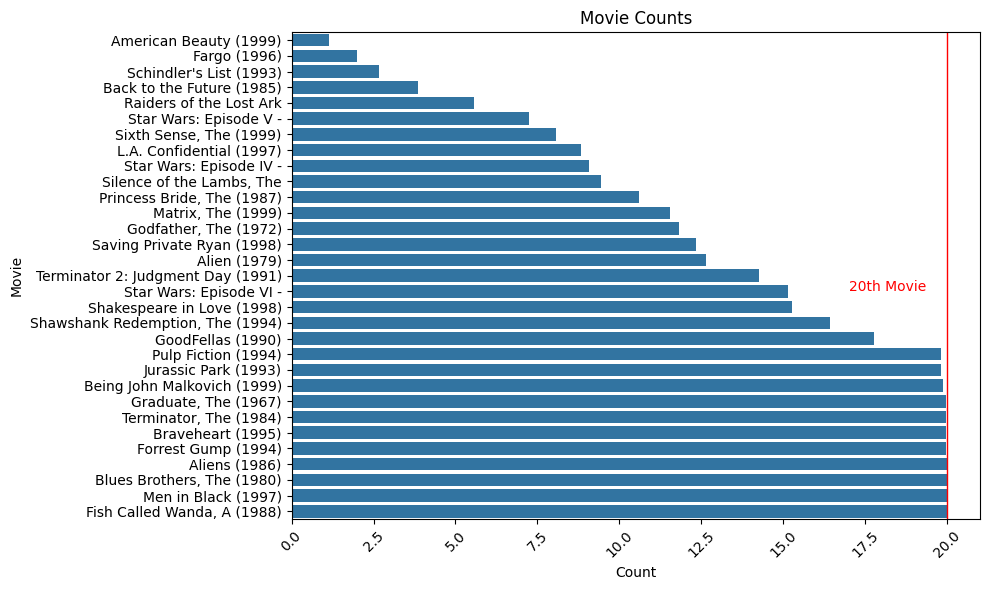

In [ ]:
plot_movies([strong_generalization_set_val_dataloader,strong_generalization_set_test_dataloader])

100%|██████████| 173/173 [02:51<00:00,  1.01it/s]


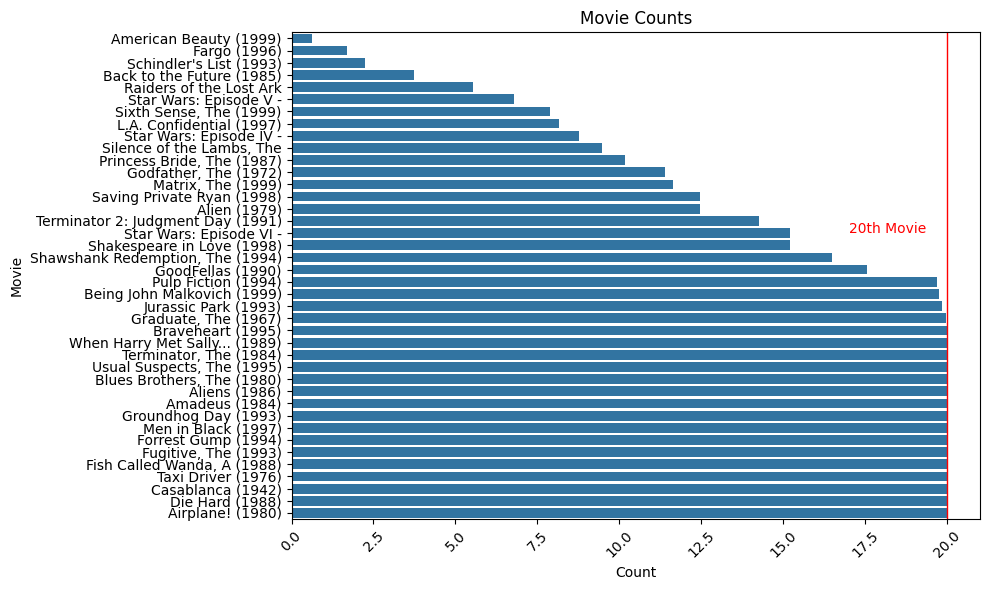

In [ ]:
plot_movies([rec_dataloader])

In [ ]:
movies_val

defaultdict(<function __main__.<lambda>()>,
            {'American Beauty (1999)': 1.1328125,
             "Schindler's List (1993)": 2.66796875,
             'Fargo (1996)': 1.99609375,
             'Back to the Future (1985)': 3.8671875,
             'Raiders of the Lost Ark (1981)': 5.5703125,
             'Star Wars: Episode V - The Empire Strikes Back (1980)': 7.234375,
             'Sixth Sense, The (1999)': 8.0625,
             'Star Wars: Episode IV - A New Hope (1977)': 9.08203125,
             'L.A. Confidential (1997)': 8.81640625,
             'Matrix, The (1999)': 11.55078125,
             'Silence of the Lambs, The (1991)': 9.42578125,
             'Princess Bride, The (1987)': 10.6015625,
             'Godfather, The (1972)': 11.80859375,
             'Saving Private Ryan (1998)': 12.3359375,
             'Shakespeare in Love (1998)': 15.26953125,
             'Being John Malkovich (1999)': 19.86328125,
             'Terminator 2: Judgment Day (1991)': 14.2421875,
      

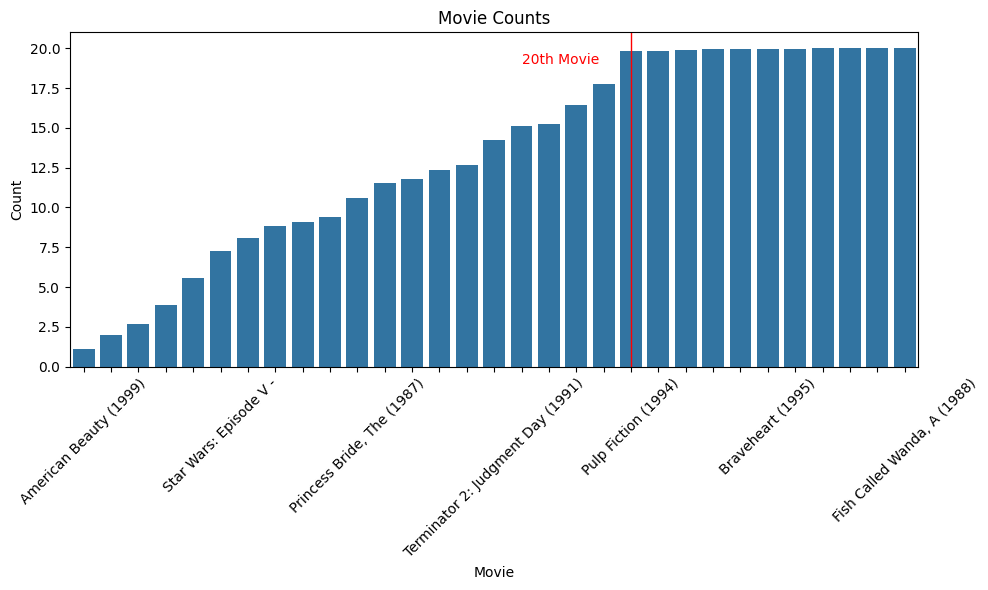

device(type='cuda', index=0)

In [ ]:
def get_teacher_values(teacher,dataloader,rank):
    output_list = []
    with torch.no_grad():
        for b in dataloader:
            inputs = b['labels'].to(rank)

            outputs = teacher(inputs)[0]


            output_list.append(outputs)

    return  torch.cat(output_list,dim=0)
# teacher = torch.load("/home/mila/e/emiliano.penaloza/LLM4REC/notebooks/vae-cf-pytorch/model.pt").to(rank)

teacher.eval()
teacher_recall = get_teacher_values(teacher,rec_dataloader,rank)


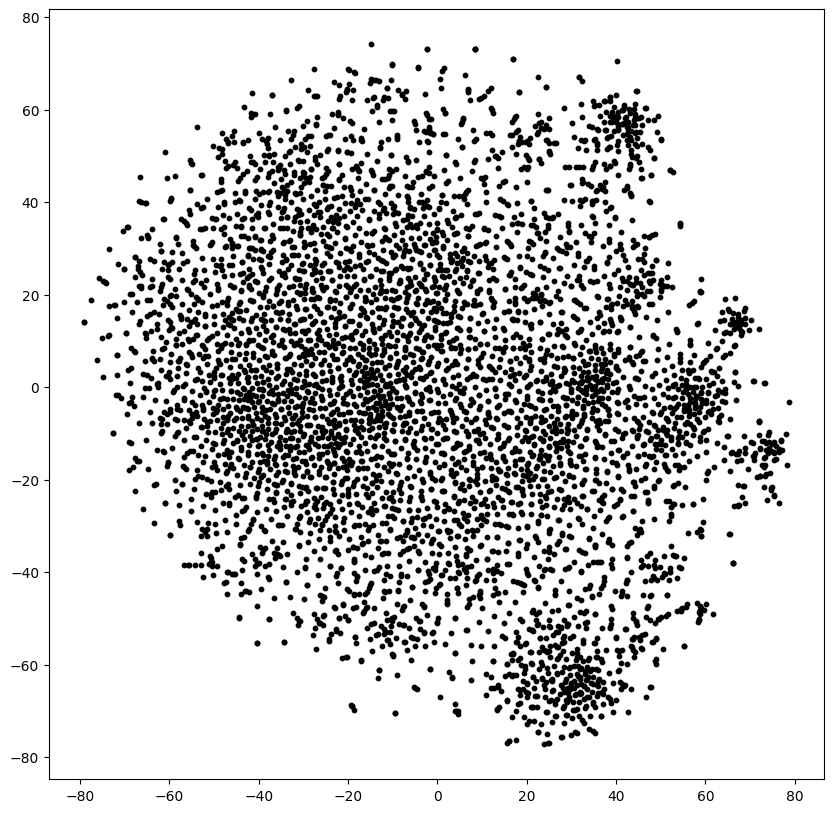

In [ ]:
#visualize embeddings using tsne 
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random


    
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
components = tsne.fit_transform(embs.cpu().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(components[:, 0], components[:, 1], s=10, c='black')
plt.show()




In [ ]:
model  = SentenceTransformer('sentence-transformers/sentence-t5-Large')

In [ ]:

model.eval()
model.to(rank)
output_list = []
with torch.no_grad():
    for i,b in tqdm(prompts.items()):
        outputs = model.encode(b)
        output_list.append(outputs)
    
outputs = torch.cat(output_list,dim=0)

100%|██████████| 6016/6016 [05:06<00:00, 19.65it/s]


TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [ ]:
outputs = np.stack(output_list)

In [ ]:
outputs

array([[ 0.00455444, -0.00191217, -0.01837577, ..., -0.06359687,
         0.0112731 ,  0.0346827 ],
       [-0.01811192, -0.00450474, -0.01353517, ..., -0.04182003,
         0.00741098,  0.03640248],
       [-0.00602347, -0.00963175, -0.01139813, ..., -0.06327579,
         0.01402011,  0.03950688],
       ...,
       [ 0.00834357,  0.00622199, -0.00538706, ..., -0.05840948,
         0.01834059,  0.03302899],
       [ 0.00028868,  0.00278231, -0.00932216, ..., -0.05650981,
         0.01513623,  0.04510693],
       [-0.01203526, -0.00930543, -0.00631105, ..., -0.05942991,
         0.02345164,  0.0405138 ]], dtype=float32)

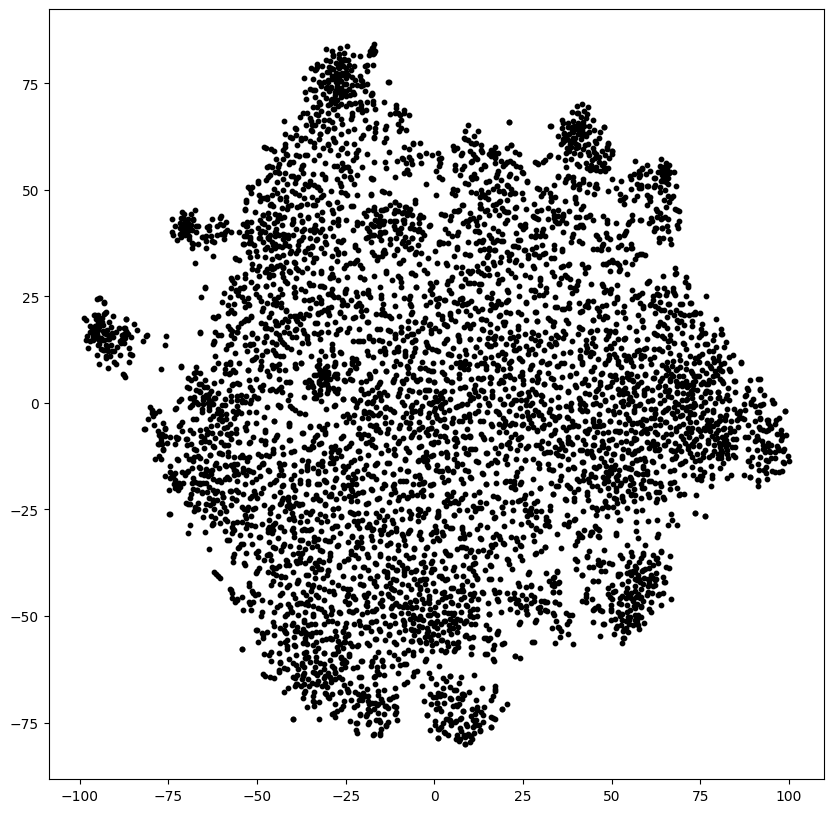

In [ ]:
#visualize 
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
components = tsne.fit_transform(outputs)
plt.figure(figsize=(10, 10))
plt.scatter(components[:, 0], components[:, 1], s=10, c='black')
plt.show()

In [ ]:

model.eval()
model.to(rank)
output_list = []
eos_token_id = model.config.eos_token_id
with torch.no_grad():
    for b in tqdm(rec_dataloader):
        b.pop('user_ids')
        b.pop('labels')
        #put the input_ids and attention mask on the gpu
        for k,v in b.items():
            b[k] = v.to(rank)
        outputs = model(**b)[0]
        
        input_ids = b['input_ids']
        eos_mask = input_ids.eq(eos_token_id).to(rank)

        if len(torch.unique_consecutive(eos_mask.sum(1))) > 1:
            raise ValueError("All examples must have the same number of <eos> tokens.")
        batch_size, _, hidden_size = outputs.shape
        sentence_representation = outputs[eos_mask, :].view(batch_size, -1, hidden_size)[:, -1, :]
        output_list.append(sentence_representation.cpu())
    
outputs = torch.cat(output_list,dim=0)

100%|██████████| 173/173 [05:16<00:00,  1.83s/it]


In [ ]:
#move outputs back back to gpu 

outputs.shape

torch.Size([5515, 1024])

In [ ]:
outputs = torch.cat(output_list,dim=0)



OutOfMemoryError: CUDA out of memory. Tried to allocate 7.72 GiB. GPU 0 has a total capacty of 19.50 GiB of which 2.48 GiB is free. Process 31013 has 17.97 GiB memory in use. Process 42831 has 36.60 GiB memory in use. Including non-PyTorch memory, this process has 17.00 GiB memory in use. Of the allocated memory 9.05 GiB is allocated by PyTorch, and 7.80 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

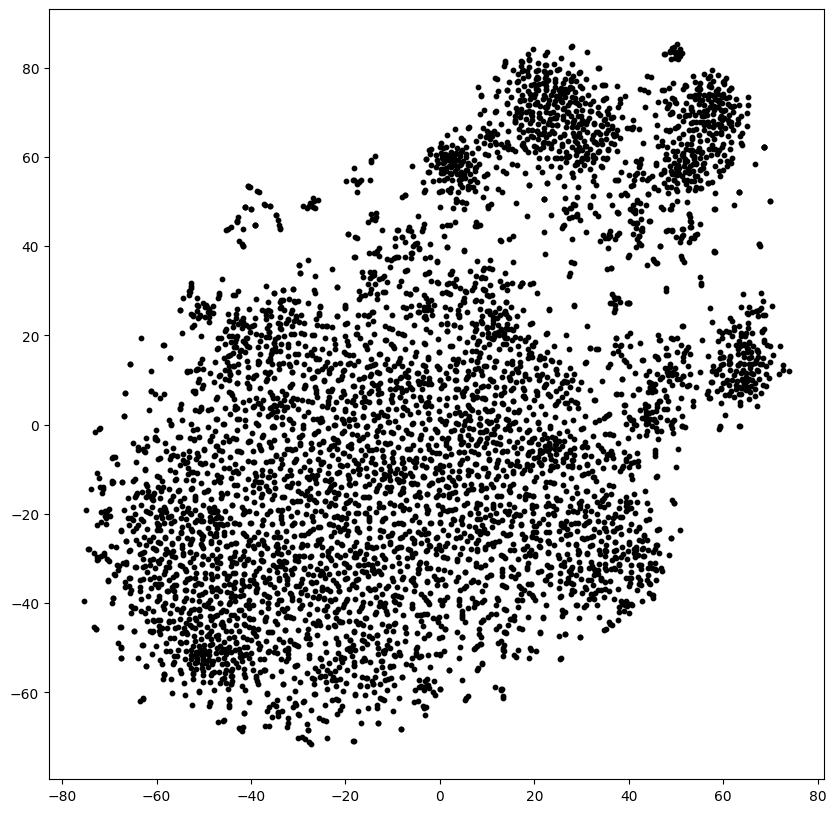

In [ ]:
#visualize 
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
components = tsne.fit_transform(outputs.cpu().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(components[:, 0], components[:, 1], s=10, c='black')
plt.show()

In [ ]:
teacher.layers  = teacher.layers[:-1]

In [ ]:
teacher_recall

0.8000000000000002

In [ ]:


r20_list = []
r20_full_list = []


with torch.no_grad():

        for i,item in enumerate(strong_generalization_set_val_dataloader):
            data_tensor = item['labels'].to('cuda' )
            
            num_users, num_items = data_tensor.shape
            train_num = int(num_items * 0.8)

            train_tensor = torch.zeros_like(data_tensor)
            val_tensor = torch.zeros_like(data_tensor)
            

            for user in range(num_users):
                # Get the indices where the tensor has 1s
                ones_indices = (data_tensor[user] == 1).nonzero(as_tuple=True)[0]
                num_ones = ones_indices.shape[0]

                
                # Calculate the number of ones to sample for training
                train_num_ones = int(num_ones * 0.8)

                
                # Generate a permutation of ones indices
                perm = torch.randperm(num_ones)
                
                # Select ones for training and validation
                train_indices = ones_indices[perm[:train_num_ones]]
                val_indices = ones_indices[perm[train_num_ones:]]
                
                train_tensor[user, train_indices] = 1
                val_tensor[user, val_indices] = 1




            recon_batch_fresh, mu, logvar = model(train_tensor)
            recon_full, _, _= model(data_tensor)


            # Exclude examples from training set
            recon_batch = torch.argsort(torch.softmax(recon_batch_fresh ,dim =1 ), dim=1)[:,-10:]
            recon_batch = recon_batch.cpu().numpy()

            #grab item['user_ids'] and make a dict with the user ids as keys and results as values
            #then use the dict to compute the metrics
            user_ids = item['user_ids']
            recon_dict = {user_ids[i].item():recon_batch[i] for i in range(len(user_ids))}
            #same for labels
            
            #get the positions where it is not zero
            labels = val_tensor.cpu().numpy()
            labels_list = []
            for i in range(len(labels)):
                labels_list.append(np.where(labels[i] != 0)[0].tolist())
            labels_dict = {user_ids[i].item():labels_list[i] for i in range(len(user_ids))}
            
            
            # n100 = ndcg_k(labels_dict,recon_dict, 100)
            r20 = Recall_at_k_batch(labels,recon_batch_fresh, 10)
            r20_full = Recall_at_k_batch(labels,recon_full, 10)
            r20_full_list.append(r20_full)

            # r50 = recall_at_k(labels_dict,recon_dict, 50)
            n100 = 0
            
            # r20 = 0
            r50 = 0



            r20_list.append(r20)

    

In [ ]:
r20_full_list

[0.578125, 0.5666666666666667]

In [ ]:
np.mean(r20_list),np.mean(r20_full_list)

(0.565625, 0.5723958333333333)

In [ ]:
from vae.metric import Recall_at_k_batch

In [ ]:
min_val_recall = -np.inf
patience_counter = 0
last_saved_epoch = 0
loss_f = get_loss(args.loss)
unfrozen = False
args.epochs = 1000
rank = 0
world_size = 1
if not args.debug:

    wandb.init(project='llm4rec', name=args.model_log_name)
    wandb.config.update(args)
    wandb.watch_called = False  # To avoid re-watching the model
    wandb.define_metric("batch")
    wandb.define_metric("epoch")
    wandb.define_metric("total_steps")

    wandb.define_metric("val_recall", step_metric="epoch")
    wandb.define_metric("val_ndcg", step_metric="epoch")
    wandb.define_metric("bce_loss", step_metric="total_steps")
    wandb.define_metric("loss", step_metric="total_steps")
    wandb.define_metric("lr", step_metric="epochs")
    
    
    
torch.cuda.set_device(rank)


loss_f = get_loss('kl')
teacher = torch.load("/home/mila/e/emiliano.penaloza/LLM4REC/notebooks/vae-cf-pytorch/model.pt").to(rank)

teacher.eval()
   


for e in (pbar := tqdm(range(args.epochs))):
    model.share_memory()

    train_Distill(args, rec_dataloader, model, teacher,prompts, optimizer, scheduler, val_items,tokenizer,pbar,e,rank)

    
    if e % 2 == 0: 
        torch.cuda.set_device(rank)
        if e % 1 == 0:    
            ranked_movies,_,outputs = generate_preds_fineTuning(args,model,prompts,val_dataloader,tokenizer,rank,100,world_size = 1)

            val_recall = outputs['recall']
            val_ndcg = ndcg_k(val_items,ranked_movies , topk=20)
            same = True
            for k in ranked_movies.keys():
                for i in ranked_movies.keys():
                    if k != i:
                        if ranked_movies[k] != ranked_movies[i]:
                            same = False
                        else:
                            same = True
            teacher_recall = get_teacher_values(teacher,val_dataloader,rank)
            teacher_strong_generalization_set_recall = get_teacher_values(teacher,strong_generalization_set_val_dataloader,rank)



                        
                        
        strong_generalization_set_ranked_movies,val_loss,outputs = generate_preds_fineTuning(args,model,prompts,strong_generalization_set_val_dataloader,tokenizer,rank,20,loss_f = loss_f,world_size = 1)
        strong_generalization_set_val_recall = outputs['recall']
        strong_generalization_set_val_ndcg = ndcg_k(strong_generalization_set_val_items,strong_generalization_set_ranked_movies , topk=20)
        pbar.set_postfix({"SAME": same,'val_loss': val_loss,'val_recall': val_recall,'ndcg': val_ndcg})
        if not args.debug :
            wandb.log({'val_recall': val_recall,
                        'val_ndcg': val_ndcg,
                        'teacher_recall': teacher_recall,
                        'teacher_strong_generalization_set_recall': teacher_strong_generalization_set_recall,
                        "strong_generalization_set_val_recall": strong_generalization_set_val_recall,
                        "strong_generalization_set_val_ndcg": strong_generalization_set_val_ndcg,
                        'validation_loss': val_loss,
                        'epoch': e})

        val_recall = 0
        val_ndcg=0
        if val_recall > min_val_recall:
            min_val_recall = val_recall
            torch.save(model.state_dict(), f'{args.scratch}/saved_model/{args.data_name}/{args.model_log_name}.pt')
            last_saved_epoch = e
            best_val = val_recall
            best_ndcg = val_ndcg
            if args.patience == patience_counter:
                print(f"Early stopping training at epoch {e}")
                break

        pbar.set_description(f"Epoch {e}: val_recall: {val_recall} ndcg: {val_ndcg} last_saved_epoch: {last_saved_epoch}")
        # model = T5ForSequenceClassification.from_pretrained(model_name, num_labels=num_movies)
        
  

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch,▁▃▆█▃▆█▃▆█▃▆█▃▅█▃▅█▃▅█▃▅█▃▅█▁▅█▁▅█▁▅█▁▅█
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
kl_loss,▁▅▃▅▅▆▆▅▅▇▇▇▇▆▅▆▅▅▅▅▅▅▆▆▆▆▆▇▇▅▄▆▆▆▇▇▆█▆▇
ll_loss,▅▃▂▃▂▄▃▂▆▅▃▆▅▃▆▄▅▄▁▆▃▅▆▅▃▄▃▂▅▄▆▄▄▃▄▆▆█▂▅
loss,▅▃▂▃▂▄▃▂▆▅▃▆▅▃▆▄▅▄▁▆▃▅▆▅▃▄▃▂▅▄▆▄▄▃▄▆▆█▂▅
loss_batch,▅▅▇▃▆▄▄▄▅▆▄▅▆▇▄▅▅▅▁▆▇▆▄▅▄▄▆▂▄▄█▇▆▄▄▃█▃▅▆
lr,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
strong_generalization_set_val_ndcg,▁▃▄█▂▄▆▅▄▄▂▆▅▇▇▇▇▆▆▇▇▆▇▆▆▆▆▅▆▅▅▅▆▆▆▅▅▅▅▅
strong_generalization_set_val_recall,▁▄▄▅▃▅▇▇▇▇▇▄▄▄▄▄▃▄▃▄▄▄▄▇██▇▇▆▆▇▇▅▅█▇▇▇▇▆
teacher_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
teacher_strong_generalization_set_recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Epoch 72: val_recall: 0 ndcg: 0 last_saved_epoch: 0:   7%|▋         | 73/1000 [01:58<25:10,  1.63s/it, SAME=0, val_loss=0.00144, val_recall=0.0612, ndcg=0.00403]                                


KeyboardInterrupt: 

In [ ]:
#enable torch to print upto 6 decimal places
torch.set_printoptions(precision=6)

In [ ]:
for b in rec_dataloader:
    teacher.eval()
    model.eval()
    logits = model(b['input_ids'].to(rank),labels=b['labels'].to(rank))[0]
    teacher_logts = teacher(b['labels'].to(rank))[0]
    softmax_logits = torch.softmax(logits,dim=1)
    softmax_teacher_logits = torch.softmax(teacher_logts,dim=1)
    # print(f"{softmax_logits=}")
    # print(f"{softmax_teacher_logits=}")
    # get positions of top 10 items 
    topk = 10
    topk_logits = torch.topk(softmax_logits,topk,dim=1)
    topk_teacher_logits = torch.topk(softmax_teacher_logits,topk,dim=1)
    print(f"{topk_logits.indices=}")
    print(f"{topk_teacher_logits.indices=}")
    
    break

topk_logits.indices=tensor([[2858, 3543,  110, 2336,  822, 2463,  608, 1152,  147, 2349],
        [2858,  110, 3543, 2336,  822,  608,  147, 2463, 2349, 1152],
        [2858,  110, 3543, 2336,  822,  608, 2463, 1152, 2349, 3211],
        [2858, 3543,  110,  822, 2336, 2463,  608, 1152,  147, 2349],
        [2858,  110, 3543, 2336,  822, 2463,  608,  147, 1152, 3211],
        [2858, 3543,  110, 2336,  822, 1152, 2463,  147,  608, 3211],
        [2858, 3543,  110, 2336,  822, 2463,  608,  147, 1152, 2349],
        [2858,  110, 3543,  822, 2336, 2463,  608,  147, 1152, 3211],
        [2858,  110, 3543,  822, 2336, 2463,  608,  147, 1152, 2349],
        [2858, 3543,  110, 2336,  822, 2463,  147,  608, 1152, 2349],
        [2858, 3543,  110, 2336,  822, 2463,  608, 1152, 2349,  147],
        [2858,  110, 3543, 2336,  822, 1152, 2463,  147,  608, 2349],
        [2858,  110, 3543, 2336,  822, 2463,  608, 1152,  147, 2349],
        [2858,  110, 3543, 2336,  822, 2463,  608, 1152,  147,  570],


### This is to load the model and evaluate

In [ ]:
load = f'{args.scratch}/saved_model/{args.data_name}/no_LORA_Finetune_w_dropout_lr_0.001_embedding_module_t5_epochs_500_l2_lambda_0.0_lora_alpha_16_lora_r_32_bce_softmax_bias_True.csv.pt'
print(f"{load =}")

load ='/home/mila/e/emiliano.penaloza/scratch/saved_model/ml-1m/no_LORA_Finetune_w_dropout_lr_0.001_embedding_module_t5_epochs_500_l2_lambda_0.0_lora_alpha_16_lora_r_32_bce_softmax_bias_True.csv.pt'


In [ ]:
model_name = f"{args.embedding_module}-large"

model = sentenceT5Classification.from_pretrained(model_name, num_labels=num_movies)

lora_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=32, lora_alpha=16, lora_dropout=0.1,
                            target_modules=["q", "v"],
                            modules_to_save=['classification_head'])
model = get_peft_model(model, lora_config)

model.to(rank)
model = DDP(model, device_ids=[rank], output_device=rank, find_unused_parameters=True)

state_dict = torch.load(load)

Some weights of sentenceT5Classification were not initialized from the model checkpoint at t5-large and are newly initialized: ['classification_head.mlp.0.weight', 'classification_head.mlp.3.weight', 'classification_head.mlp.7.weight', 'classification_head.mlp.7.bias', 'classification_head.mlp.3.bias', 'classification_head.mlp.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# clear cuda memor y 
torch.cuda.empty_cache()

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-large')
tokenizer.add_special_tokens({'additional_special_tokens': ['<SEP>']})

model.eval()
model.to(rank)
embeddings = []
for b in val_dataloader:
    input_ids = b['input_ids'].to(rank)
    attention_mask = b['attention_mask'].to(rank)
    labels = b['labels'].to(rank)
    outputs = model.module.transformer(input_ids=input_ids,attention_mask=attention_mask)
    embeddings.append(outputs[0][:,0,:].detach().cpu().numpy())


/home/mila/e/emiliano.penaloza/llm4rec/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
#make tsne projection of embeddings 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsne_results = tsne.fit_transform(np.concatenate(embeddings))


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 5516 samples in 0.002s...
[t-SNE] Computed neighbors for 5516 samples in 2.486s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5516
[t-SNE] Computed conditional probabilities for sample 2000 / 5516
[t-SNE] Computed conditional probabilities for sample 3000 / 5516
[t-SNE] Computed conditional probabilities for sample 4000 / 5516
[t-SNE] Computed conditional probabilities for sample 5000 / 5516
[t-SNE] Computed conditional probabilities for sample 5516 / 5516
[t-SNE] Mean sigma: 0.313285
[t-SNE] KL divergence after 50 iterations with early exaggeration: 73.436249
[t-SNE] KL divergence after 300 iterations: 2.643759


<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

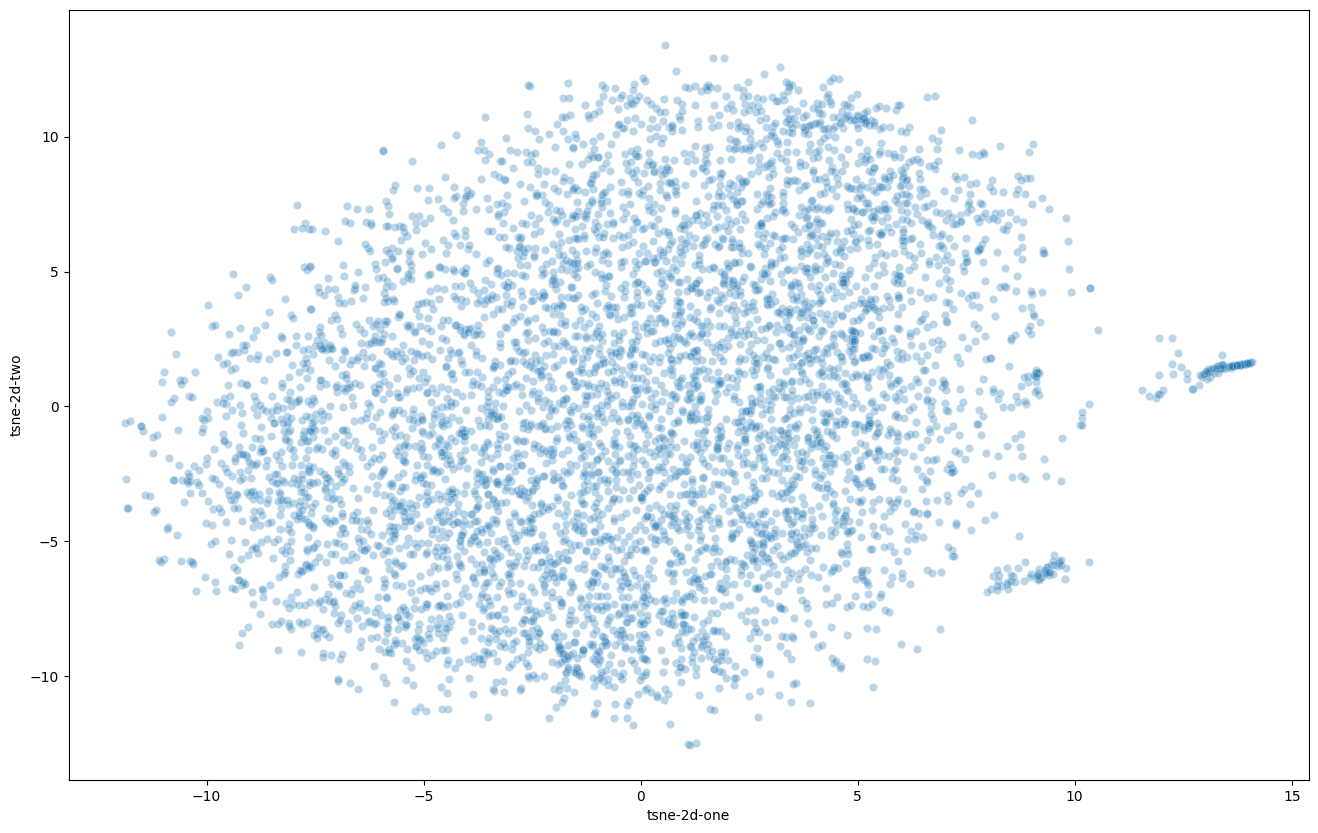

In [ ]:
#view embeddings
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

#plot 
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=df_subset,
    legend="full",
    alpha=0.3
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

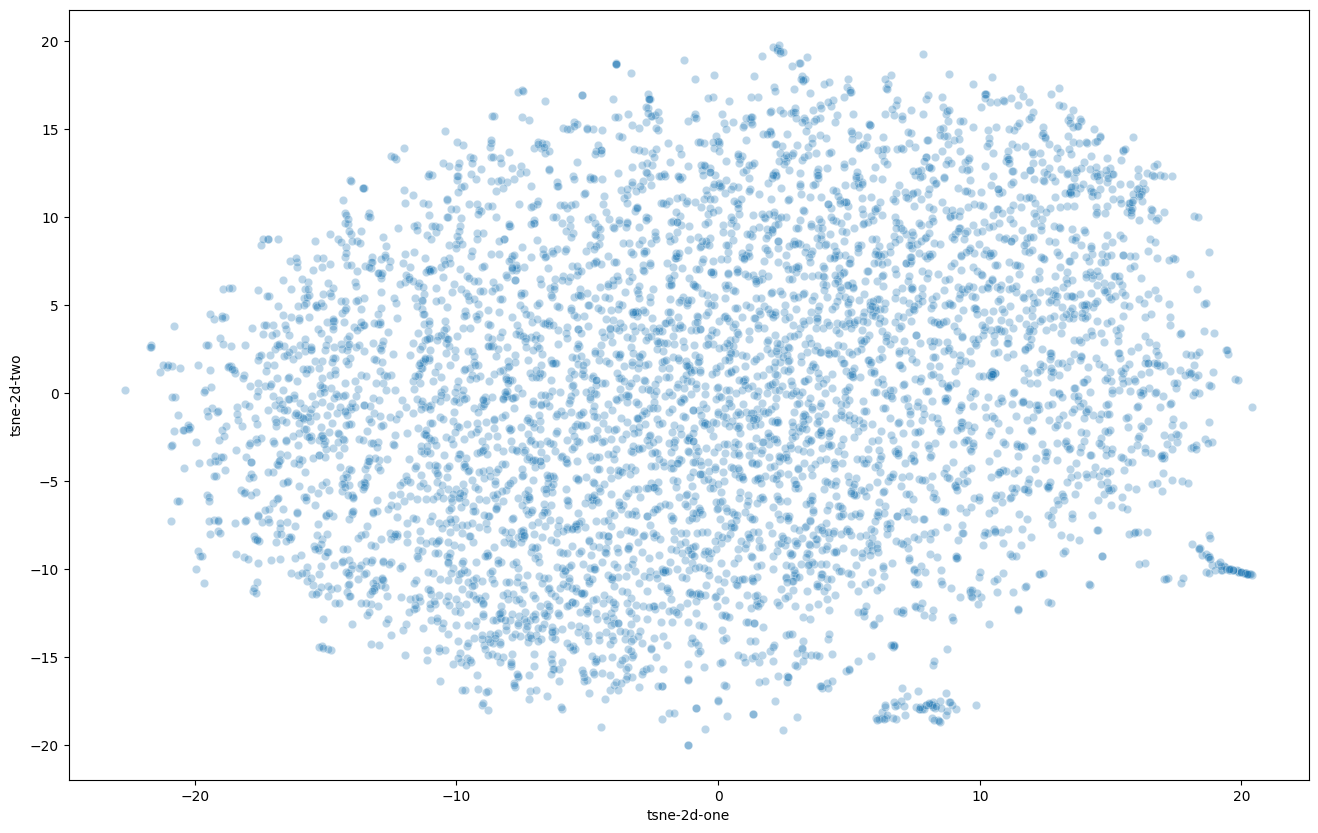

In [ ]:
#view embeddings
df_subset = pd.DataFrame()
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

#plot 
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=df_subset,
    legend="full",
    alpha=0.3
)

In [ ]:
ranked

In [ ]:
ranked_movies

In [ ]:
loss_final

0.10170748602184984

In [ ]:

val_recall = recall_at_k(training_items,ranked_movies , topk=20)


In [ ]:
val_recall

0.28518100576392147

In [ ]:
pred_movies = set(ranked_movies[40])

read_movies = set(training_items[40])

right = pred_movies.intersection(read_movies)
right

{161,
 466,
 653,
 912,
 919,
 969,
 1127,
 1197,
 1204,
 1254,
 1262,
 1272,
 1375,
 2115,
 2202,
 2662,
 2944,
 2968,
 2987,
 3628}

In [ ]:
val_recall

0.28518100576392147

In [ ]:
rolling_loss = 0 
with torch.no_grad():
    model.eval()
    rolling_proportion =0
    k = 0 
    for b,item in enumerate(rec_dataloader):
    
        user_ids = sum(item.pop('user_ids').cpu().tolist(),[])

        
        movie_emb = model(**item)[0]
        if loss_f: 
            rolling_loss += loss_f(movie_emb,item['labels'].to(args.device)).item()
        else:
            rolling_loss = 0
        labs = item['labels']
        l = [ ]
        for u in labs: 
            l.append(torch.nonzero(u).flatten().tolist())
        for i,m in enumerate(movie_emb):
           
            k+=1 
            movies = set(torch.argsort(m)[-len(l[i]):].tolist() )

            intersect = movies.intersection(set(l[i]))
          

            proportion = len(intersect)/len(l[i])
            
            rolling_proportion += proportion
    print(f"{rolling_proportion/k=}")
        

       

            




rolling_proportion/k=0.9995515653084583


In [ ]:
user_ids,item['labels'][0]

([1150, 4610, 2800, 1830, 950, 2830, 1240, 2700, 5200, 4870],
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [ ]:
labs =torch.nonzero(item['labels'][0]).flatten().tolist()

In [ ]:
len(set(training_items[1150]).intersection(set(labs)))


227

In [ ]:
len(set(training_items[1150]))

1176

In [ ]:
labs = item['labels']
l = [ ]
for u in labs: 
    l.append(torch.nonzero(u).flatten().tolist())


In [ ]:
len(labs)

10

torch.Size([10, 3953])

In [ ]:
movie_emb[3][:30]

tensor([1506, 2131, 3433, 3345,  878,  302, 3775,  993,  177, 1511, 3275, 3216,
        1241, 3880, 1823, 3623, 1072, 3205, 1858, 1830, 2543, 3378,  385, 2467,
        1460, 3050,  462,  843, 2209,  129], device='cuda:0')

In [ ]:
train_dataloader = rec_dataloader
loss = get_loss('bce_softmax')
rolling_l = 0 
for b in train_dataloader:
    
    optimal_labels = b['labels'] / b['labels'].sum(dim = 1).unsqueeze(1)
    
    l = nn.BCELoss(reduction='none')(optimal_labels, b['labels'].float()).mean(dim= 1).mean()


    rolling_l += l

print(f"Optimal Loss = {rolling_l/len(train_dataloader)}")

Optimal Loss = 0.10157088935375214


In [ ]:
cleanup()

In [ ]:
from model.MF import T5MappingVAE

In [ ]:

model = T5MappingVAE.from_pretrained('t5-base', num_labels=num_movies)

Some weights of T5MappingVAE were not initialized from the model checkpoint at t5-base and are newly initialized: ['decoder.layers.0.weight', 'classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight', 'decoder.layers.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#print weights for model.decoder:
model.decoder.layers


ModuleList(
  (0): Linear(in_features=200, out_features=3953, bias=True)
)

In [ ]:
# test with random input 
x = torch.randn(100,3000)
x.shape
out = model(x)

In [ ]:
model

MultiDAE(
  (layers): ModuleList(
    (0): Linear(in_features=3000, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=3000, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
)

In [27]:
import pandas as pd 
df = pd.read_csv('/home/mila/e/emiliano.penaloza/LLM4REC/model_logs/ml-1m/parameter_sweep.csv')

In [30]:
df.iloc[7,:].model_name

't5_classification_embedding_module_t5_classification_l2_lambda_0.0_lora_r_32_scheduler_cosine_warmup_0.0001_0.2.csv'